# Importações

In [1]:
#!pip install scikit-learn shap pandas numpy matplotlib xgboost seaborn 

In [2]:
import pickle
import shap
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np  

# Pré-processamento e pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Modelos de ML
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# Transformadores personalizados
from transformers import DateFeatureExtractor, CapTransformer, RareCategoryGrouper, TopNMultiLabelTransformer, BudgetRuntimeRatioTransformer

# Carregando dataset

In [3]:
df = pd.read_csv('../data/filmes_filtrados_credits.csv')

# Dividindo os dados
- X_train, X_test, y_train, y_test

In [4]:
numerical_cols = ['popularity', 'budget', 'runtime', 'budget_runtime_ratio']
categorical_col = ['original_language']
date_column = 'release_date'

X = df.drop(columns=['vote_average'])
y = df['vote_average']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# Transformadores
- MultiLabelBinarize -> Generos Cinematográficos, Produtora e Atores
- Data -> Extrai o ano e o mês das datas
- Outliers -> Cap, Log + Cap, Winsorizer
- Agrupamento de categorias raras -> original language
- Criação da feature budget_runtime_ratio

In [5]:
# Transformers personalizados por coluna
credits_transformer = TopNMultiLabelTransformer(top_n=60, prefix='credits')
genres_transformer = TopNMultiLabelTransformer(top_n=20, prefix='genre')
prod_companies_transformer = TopNMultiLabelTransformer(top_n=60, prefix='prod_company')

# Treinamento
- Modelo XGBRegressor
- Modelo SVR
- Modelo RandomForest

### Definindo Kf

In [6]:
# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

### XGBRegressor

In [7]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico 
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento geral com ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')


pipeline = Pipeline([
    ('budget_ratio', BudgetRuntimeRatioTransformer()),
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=87, n_jobs=-1))
])

param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}


XGBRegressor_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

XGBRegressor_rand.fit(X_train, y_train)

print("Melhores parâmetros:", XGBRegressor_rand.best_params_)
print("Melhor R² (validação cruzada):", XGBRegressor_rand.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'regressor__colsample_bytree': np.float64(0.8696231377727208), 'regressor__learning_rate': np.float64(0.05992056035524427), 'regressor__max_depth': 5, 'regressor__n_estimators': 241, 'regressor__subsample': np.float64(0.8173221947525602)}
Melhor R² (validação cruzada): 0.4980542795679779


### SVR

In [8]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento completo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')



pipeline_svr = Pipeline([
    ('budget_ratio', BudgetRuntimeRatioTransformer()),
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

param_dist_svr = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),
    'regressor__epsilon': uniform(0.01, 0.3),
    'regressor__gamma': ['scale', 'auto']
}

svm_rand = RandomizedSearchCV(
    estimator=pipeline_svr,
    param_distributions=param_dist_svr,
    n_iter=20,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

svm_rand.fit(X_train, y_train)
print("Melhores parâmetros SVR:", svm_rand.best_params_)
print("Melhor R² (CV) SVR:", svm_rand.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros SVR: {'regressor__C': np.float64(4.217516020234043), 'regressor__epsilon': np.float64(0.29647041307396826), 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
Melhor R² (CV) SVR: 0.47050852828571327


### RandomForest

In [9]:
# Numérico
num_pipeline = Pipeline([
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# Categórico
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processamento completo
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col),
    ('credits', credits_transformer, 'credits'),
    ('genres', genres_transformer, 'genres'),
    ('prod_companies', prod_companies_transformer, 'production_companies')
], remainder='passthrough')

pipeline_rf = Pipeline([
    ('budget_ratio', BudgetRuntimeRatioTransformer()),
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=87, n_jobs=-1))
])

param_dist_rf = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=kf,
    scoring='r2',
    error_score='raise',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

rf_rand.fit(X_train, y_train)
print("Melhores parâmetros RF:", rf_rand.best_params_)
print("Melhor R² (CV) RF:", rf_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros RF: {'regressor__max_depth': 14, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 376}
Melhor R² (CV) RF: 0.46823092995495796


# Avaliação dos modelos

In [10]:
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MedAE': median_absolute_error(y_test, y_pred)
    }

In [11]:
results = []
results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
print(results)

[{'Modelo': 'XGBRegressor', 'R²': 0.5071375310581621, 'MAE': 0.4890054096948103, 'RMSE': np.float64(0.6401990124242565), 'MedAE': 0.3925948448181149}]


In [12]:
results = []
results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("RandomForestRegressor", rf_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("SVR", svm_rand.best_estimator_, X_test, y_test))
results_df = pd.DataFrame(results)
print(results_df)

                  Modelo        R²       MAE      RMSE     MedAE
0           XGBRegressor  0.507138  0.489005  0.640199  0.392595
1  RandomForestRegressor  0.471798  0.507687  0.662754  0.405450
2                    SVR  0.459549  0.508660  0.670395  0.398645


# Graficos

## Shap

Valores SHAP calculados com sucesso. Gerando gráficos...


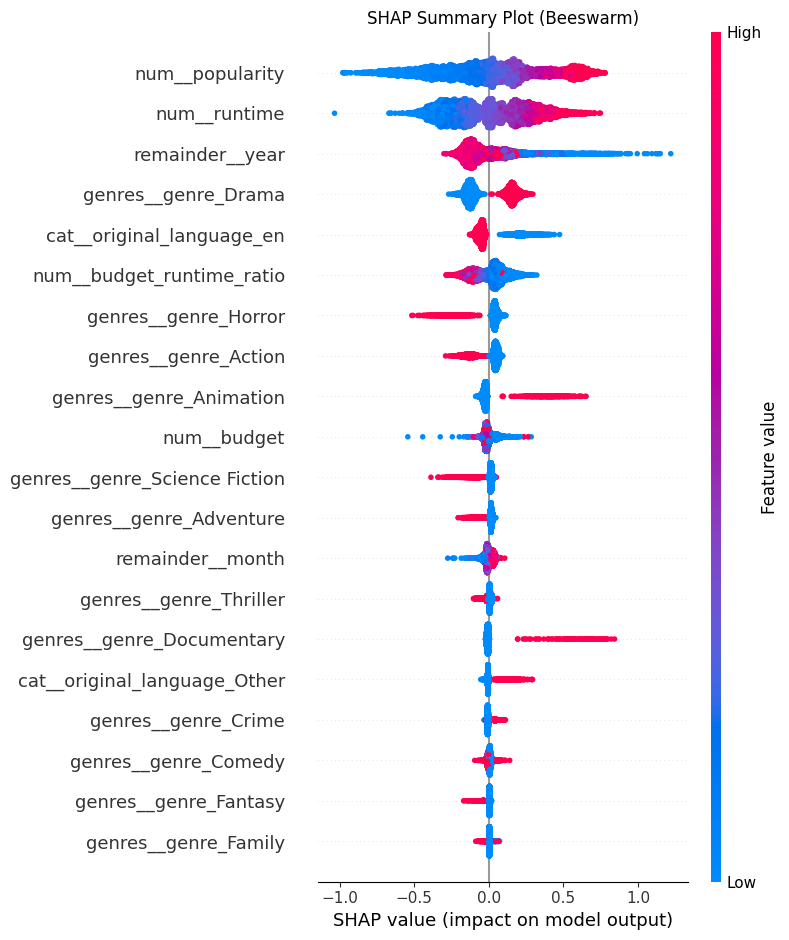

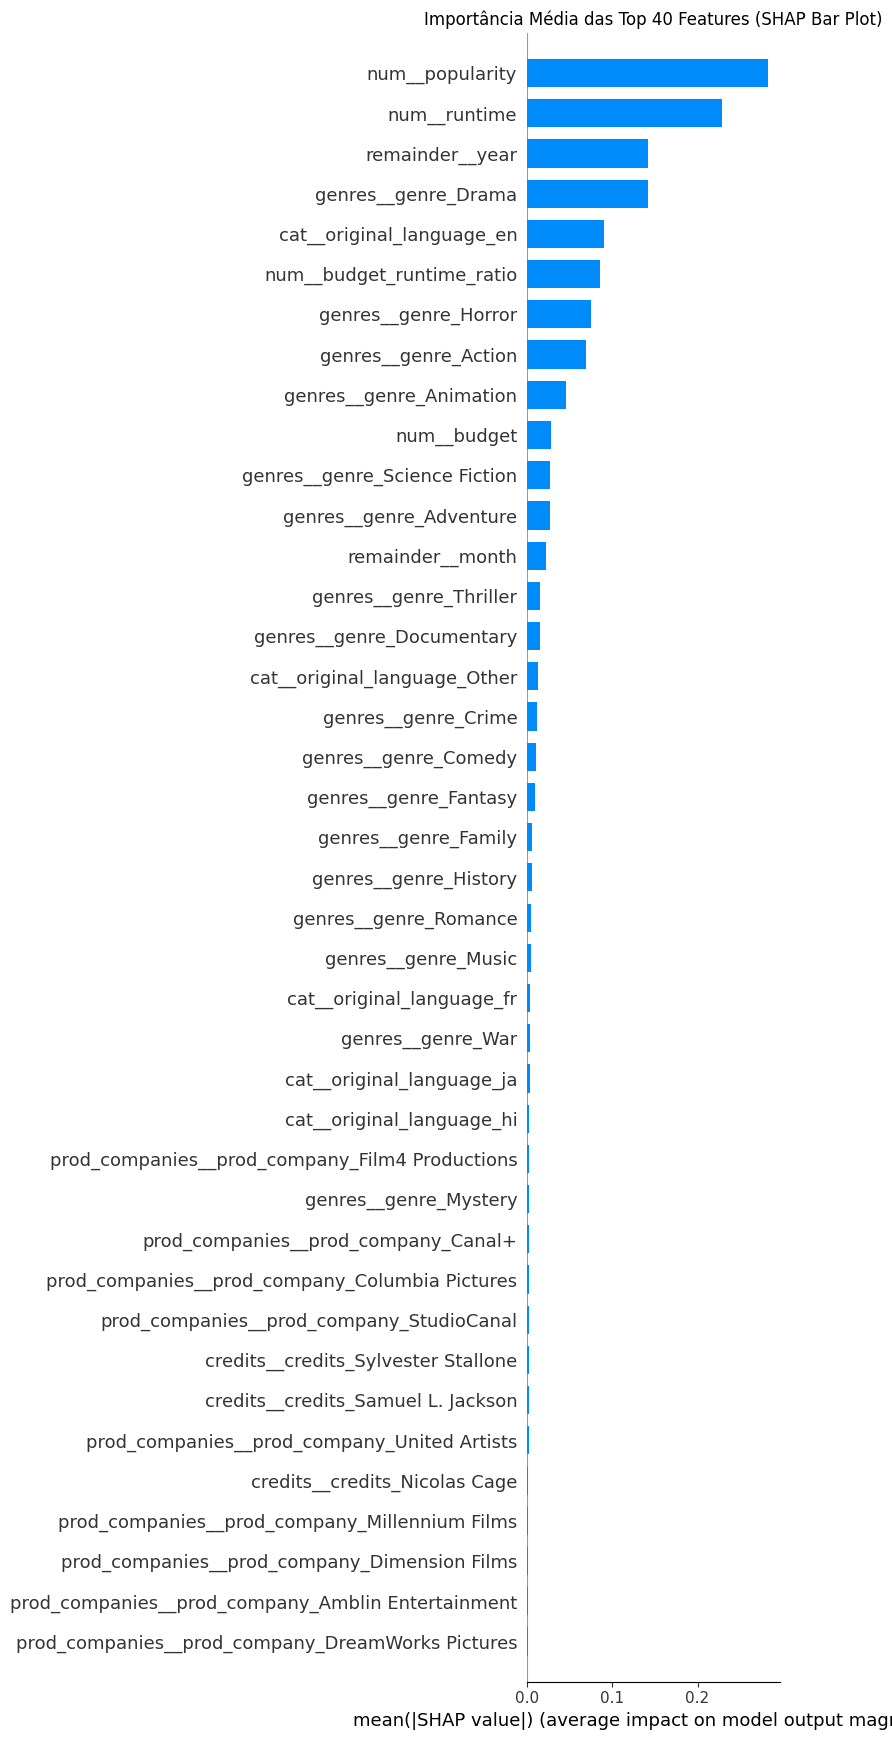

In [13]:
# 1. Obter o melhor pipeline treinado
best_pipeline = XGBRegressor_rand.best_estimator_

# 2. Criar um pipeline APENAS com os passos de pré-processamento
preprocessing_pipeline = Pipeline(best_pipeline.steps[:-1])
X_train_transformed = preprocessing_pipeline.transform(X_train)


# 3. Obter os nomes das features do ColumnTransformer (que é o passo 'preprocess')
col_transformer = best_pipeline.named_steps['preprocess']
feature_names = col_transformer.get_feature_names_out()

# 4. Criar um DataFrame com os dados transformados para melhor visualização no SHAP
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

# 5. Extrair o modelo final e calcular os valores SHAP
xgb_model = best_pipeline.named_steps['regressor']
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_train_transformed_df) # A API moderna do SHAP usa o explainer como uma função
print("Valores SHAP calculados com sucesso. Gerando gráficos...")

# 6. Gerar os gráficos
plt.figure()
plt.title("SHAP Summary Plot (Beeswarm)")
shap.summary_plot(shap_values, X_train_transformed_df, show=False)
plt.tight_layout() 
plt.show()
plt.figure()
plt.title("Importância Média das Top 40 Features (SHAP Bar Plot)")
shap.summary_plot(shap_values, X_train_transformed_df, plot_type="bar", show=False, max_display=40)
plt.tight_layout()
plt.show()

## Importance

In [14]:
feature_importance = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': feature_importance
})

sorted_importance_df = importance_df.sort_values(
    by='SHAP Importance', 
    ascending=False
).reset_index(drop=True)

print("Ranking de Importância das Features (baseado em SHAP):")
pd.set_option('display.max_rows', None)
print(len(sorted_importance_df))
display(sorted_importance_df) 

Ranking de Importância das Features (baseado em SHAP):
159


,Feature,SHAP Importance
0,num__popularity,0.282606
1,num__runtime,0.229076
2,remainder__year,0.142232
3,genres__genre_Drama,0.141840
4,cat__original_language_en,0.089758
5,num__budget_runtime_ratio,0.085547
6,genres__genre_Horror,0.074909
7,genres__genre_Action,0.069541
8,genres__genre_Animation,0.045438
9,num__budget,0.028582


# Gerando Pickle

In [ ]:
'''
with open(best_model.pkl', 'wb') as f:
    pickle.dump(XGBRegressor_rand, f)

with open('svr_pipeline.pkl', 'wb') as f:
    pickle.dump(svm_rand, f)

with open('rf_pipeline.pkl', 'wb') as f:
    pickle.dump(rf_rand, f)
'''